In [155]:
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [156]:
import warnings
warnings.filterwarnings('ignore')

In [157]:
### 
### This includes code copied and pasted from the main methods used for the website in BioKlustering-Website/BioKlustering/mlmodel/parser/spectralClustering.py
### These methods are copy-pasted instead of directly included due to difficulties importing Django classes for running locally without running the server
###

# parseFasta(data) credit to Luke
def parseFasta(data):
    d = {fasta.id : str(fasta.seq) for fasta in SeqIO.parse(data, "fasta")}
    pd.DataFrame([d])
    s = pd.Series(d, name='Sequence')
    s.index.name = 'ID'
    s.reset_index()
    return pd.DataFrame(s)

# this method credit to Zhiwen
def get_kmer_table(paths,k_min,k_max):
    genes,gene_len,output_df = read_fasta(paths)
    count_vect = CountVectorizer(analyzer='char', ngram_range=(k_min, k_max))
    X = count_vect.fit_transform(genes)
    chars = count_vect.get_feature_names()
    kmers = X.toarray()
    kmer_freq = []
    for i in range(len(genes)):
        kmer_freq.append(kmers[i] / gene_len[i])
    input = pd.DataFrame(kmer_freq, columns=chars)
    return input, output_df

# this method credit to Zhiwen
def get_gene_sequences(filename):
    genes = []
    for record in SeqIO.parse(filename, "fasta"):
        genes.append(str(record.seq))
    return genes

# this method credit to Zhiwen
# genes: a list of gene sequences, which can directly be generated from get_gene_sequences().
def get_gene_len(genes):
    gene_len = []

    for i in range(len(genes)):
        gene_len.append(len(genes[i]))
    return gene_len

# this method credit to Zhiwen
def read_fasta(paths):
    all_genes = []
    all_gene_len = []
    output_df = pd.DataFrame()
    
    for path in paths:
        virus = parseFasta(path)
        output_df = pd.concat([output_df, virus])
        virus = virus.drop_duplicates(keep="last")
        genes_seq = get_gene_sequences(path)
        gene_len = get_gene_len(genes_seq)
        all_genes = all_genes + genes_seq
        all_gene_len = all_gene_len + gene_len
    return all_genes,all_gene_len,output_df

# this method takes predits the input and make prediction using spectral clustering
# paths: a list of strings. contains file paths
# k_min: int. min of kmer
# k_max: int. max of kmer
# num_cluster: int. number of clusters
# assignLabels: a string. the way to assign label at the final stage of spectral clustering. Can be "kmeans" or "discretize"
def spectral_clustering(num_cluster, assignLabels, paths, k_min = 2, k_max = 3, seed = 0):
    kmer_table, output_df = get_kmer_table(paths, k_min, k_max)
    # if len(kmer_table) < num_cluster:
    #     raise ValueError()
    spectral_clustering = SpectralClustering(n_clusters=num_cluster, assign_labels=assignLabels, random_state=0)
    labels = spectral_clustering.fit_predict(kmer_table)
    output_df.insert(0, "Labels", labels)
    return labels,output_df
# this method takes prints the spectral clustering result by using PCA
# paths: a list of strings. contains file paths
# k_min: int. min of kmer
# k_max: int. max of kmer
# num_cluster: int. number of clusters
# assignLabels: a string. the way to assign label at the final stage of spectral clustering. Can be "kmeans" or "discretize"
def PCA_show_spectural_clustering(num_cluster, assignLabels, paths, filename, k_min=2, k_max=3, seed=0):
    kmer_table,output_df = get_kmer_table(paths, k_min, k_max);
    prediction = SpectralClustering(n_clusters=num_cluster, assign_labels=assignLabels, random_state=seed).fit_predict(
        kmer_table)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(kmer_table)
    d = {'dimension1': pca_result[:, 0], 'dimension2': pca_result[:, 1], 'label': prediction}
    df = pd.DataFrame(d)
    for i in range(num_cluster):
        label = df.loc[df['label'] == i]
        color = 'C' + str(i)
        plt.scatter(label['dimension1'].tolist(), label['dimension2'].tolist(), c=color)
    plt.xlabel('principal component 1')
    plt.ylabel('principal component 2')
    plt.title('Unsupervised Spectral clustring with ' + assignLabels + ' assign label method')
    df.to_csv('spectral/' + filename + "_PCA.csv")

# NOTE: do we also want to show users the optimal k_min and k_max for users here?
def intuitive_semi_supervised(num_cluster, file_path, label_path, assignLabels = "none", k_min=2, k_max=3, seed=699):
    labels = pd.read_csv(label_path)
    label_list = labels["Labels"].to_list()
    inputlabels = labels["Labels"].to_list()

    print(label_list)

    unique_given_labels = get_unique_numbers(label_list)
    if num_cluster < len(unique_given_labels) - 1 and -1 in unique_given_labels:
        num_cluster = len(unique_given_labels) - 1
    if num_cluster < len(unique_given_labels) and -1 not in unique_given_labels:
        num_cluster = len(unique_given_labels)
    total_len = len(label_list)
    print(total_len)
    unknown_label = -1
    total_labeled = 0
    optimal_accuracy = 0
    optimal_k_min = 0
    optimal_k_max = 0
    for i in label_list:
        if label_list[i] != unknown_label:
            total_labeled = total_labeled + 1
    res = [0] * total_len
    
    if (assignLabels == "none"):
        
        for i in range(k_min, k_max + 1):
            for j in range(i, k_max + 1):
                temp_k_min = i
                temp_k_max = j
                kmer_table,output_df = get_kmer_table(file_path, temp_k_min, temp_k_max)
                spectral_clustering = SpectralClustering(n_clusters=num_cluster, assign_labels="kmeans",
                                                     random_state=seed)
                labels = spectral_clustering.fit_predict(kmer_table)

                given_labels_count = {}
                labels_list = list(inputlabels)
                for label in unique_given_labels:
                    given_labels_count[label] = labels_list.count(label)
                unique_predicted_labels = get_unique_numbers(labels)
                predicted_labels_count = {}
                for label in unique_predicted_labels:
                    predicted_labels_count[label] = (labels == label).sum()
                max_item = max(predicted_labels_count, key=predicted_labels_count.get)
                if -1 in given_labels_count.keys():
                    del given_labels_count[-1]
                given_labels_count = sorted(given_labels_count.items(), key=lambda x: x[1], reverse=True)
                predicted_labels_count = sorted(predicted_labels_count.items(), key=lambda x: x[1], reverse=True)

                map_predict_to_actual = {}
                for label_GIVEN_dict_entry in given_labels_count:
                    label_GIVEN = label_GIVEN_dict_entry[0]
                    predicted_labels_count_GIVEN = {}
                    label_GIVEN_idx = [index for (index, item) in enumerate(labels_list) if item == label_GIVEN]
                    res_GIVEN = [labels[k] for k in label_GIVEN_idx]
                    unique_predicted_labels_GIVEN = get_unique_numbers(res_GIVEN)
                    for lab in unique_predicted_labels_GIVEN:
                        predicted_labels_count_GIVEN[lab] = (res_GIVEN == lab).sum()
                    map_predict_to_actual[max(predicted_labels_count_GIVEN, key=predicted_labels_count_GIVEN.get)] = label_GIVEN

                
                max_value = max(unique_given_labels) + 1
                for upl in unique_predicted_labels:
                    if upl not in map_predict_to_actual.keys():
                        print(f"{upl} mapped to {max_value}")
                        map_predict_to_actual[upl] = max_value
                        max_value += 1

                # predictions_final contains the final results
                # it takes care of the case when num_class > number of unique labels given
                predictions_tmp = []
                for k in range(len(labels)):
                    if labels[k] in map_predict_to_actual.keys():
                        predictions_tmp.append(map_predict_to_actual[labels[k]])
                    else:
                        predictions_tmp.append(map_predict_to_actual[max_item])

                correct_count = 0
                temp_accuracy = 0
                for k in range(len(label_list)):
                    if (label_list[k] != unknown_label):
                        if (label_list[k] == predictions_tmp[k]):
                            correct_count += 1
                temp_accuracy = correct_count / total_labeled
                if (temp_accuracy > optimal_accuracy):
                    optimal_accuracy = temp_accuracy
                    optimal_k_min = i
                    optimal_k_max = j
                    res = labels
                
        for i in range(k_min, k_max + 1):
            for j in range(i, k_max + 1):
                temp_k_min = i
                temp_k_max = j
                kmer_table,output_df = get_kmer_table(file_path, temp_k_min, temp_k_max)
                spectral_clustering = SpectralClustering(n_clusters=num_cluster, assign_labels="discretize",
                                                     random_state=seed)
                labels = spectral_clustering.fit_predict(kmer_table)

                given_labels_count = {}
                labels_list = list(inputlabels)
                for label in unique_given_labels:
                    given_labels_count[label] = labels_list.count(label)
                unique_predicted_labels = get_unique_numbers(labels)
                predicted_labels_count = {}
                for label in unique_predicted_labels:
                    predicted_labels_count[label] = (labels == label).sum()
                max_item = max(predicted_labels_count, key=predicted_labels_count.get)
                if -1 in given_labels_count.keys():
                    del given_labels_count[-1]
                given_labels_count = sorted(given_labels_count.items(), key=lambda x: x[1], reverse=True)
                predicted_labels_count = sorted(predicted_labels_count.items(), key=lambda x: x[1], reverse=True)

                map_predict_to_actual = {}
                for label_GIVEN_dict_entry in given_labels_count:
                    label_GIVEN = label_GIVEN_dict_entry[0]
                    predicted_labels_count_GIVEN = {}
                    label_GIVEN_idx = [index for (index, item) in enumerate(labels_list) if item == label_GIVEN]
                    res_GIVEN = [labels[k] for k in label_GIVEN_idx]
                    unique_predicted_labels_GIVEN = get_unique_numbers(res_GIVEN)
                    for lab in unique_predicted_labels_GIVEN:
                        predicted_labels_count_GIVEN[lab] = (res_GIVEN == lab).sum()
                    map_predict_to_actual[max(predicted_labels_count_GIVEN, key=predicted_labels_count_GIVEN.get)] = label_GIVEN

                
                max_value = max(unique_given_labels) + 1
                for upl in unique_predicted_labels:
                    if upl not in map_predict_to_actual.keys():
                        print(f"{upl} mapped to {max_value}")
                        map_predict_to_actual[upl] = max_value
                        max_value += 1

                # predictions_final contains the final results
                # it takes care of the case when num_class > number of unique labels given
                predictions_tmp = []
                for k in range(len(labels)):
                    if labels[k] in map_predict_to_actual.keys():
                        predictions_tmp.append(map_predict_to_actual[labels[k]])
                    else:
                        predictions_tmp.append(map_predict_to_actual[max_item])

                correct_count = 0
                temp_accuracy = 0
                for k in range(len(label_list)):
                    if (label_list[k] != unknown_label):
                        if (label_list[k] == predictions_tmp[k]):
                            correct_count += 1
                temp_accuracy = correct_count / total_labeled
                if (temp_accuracy > optimal_accuracy):
                    optimal_accuracy = temp_accuracy
                    optimal_k_min = i
                    optimal_k_max = j
                    res = labels
        print("The optimal accuracy based on labeled sequences is: " + str(optimal_accuracy))
        print("The optimal k_min is: " + str(optimal_k_min))
        print("The optimal k_max is: " + str(optimal_k_max))

        res = np.array(res)
    else:
        for i in range(k_min, k_max + 1):
            for j in range(i, k_max + 1):
                temp_k_min = i
                temp_k_max = j
                kmer_table,output_df = get_kmer_table(file_path, temp_k_min, temp_k_max)
                spectral_clustering = SpectralClustering(n_clusters=num_cluster, assign_labels=assignLabels,
                                                     random_state=seed)
                labels = spectral_clustering.fit_predict(kmer_table)
                # Get the counts for the given labels and the predicted labels
                given_labels_count = {}
                labels_list = list(inputlabels)
                for label in unique_given_labels:
                    given_labels_count[label] = labels_list.count(label)
                unique_predicted_labels = get_unique_numbers(labels)
                predicted_labels_count = {}
                for label in unique_predicted_labels:
                    predicted_labels_count[label] = (labels == label).sum()
                max_item = max(predicted_labels_count, key=predicted_labels_count.get)
                if -1 in given_labels_count.keys():
                    del given_labels_count[-1]
                given_labels_count = sorted(given_labels_count.items(), key=lambda x: x[1], reverse=True)
                predicted_labels_count = sorted(predicted_labels_count.items(), key=lambda x: x[1], reverse=True)

                map_predict_to_actual = {}
                for label_GIVEN_dict_entry in given_labels_count:
                    label_GIVEN = label_GIVEN_dict_entry[0]
                    predicted_labels_count_GIVEN = {}
                    label_GIVEN_idx = [index for (index, item) in enumerate(labels_list) if item == label_GIVEN]
                    res_GIVEN = [labels[k] for k in label_GIVEN_idx]
                    unique_predicted_labels_GIVEN = get_unique_numbers(res_GIVEN)
                    for lab in unique_predicted_labels_GIVEN:
                        predicted_labels_count_GIVEN[lab] = (res_GIVEN == lab).sum()
                    map_predict_to_actual[max(predicted_labels_count_GIVEN, key=predicted_labels_count_GIVEN.get)] = label_GIVEN

                
                max_value = max(unique_given_labels) + 1
                for upl in unique_predicted_labels:
                    if upl not in map_predict_to_actual.keys():
                        map_predict_to_actual[upl] = max_value
                        max_value += 1

                # predictions_final contains the final results
                # it takes care of the case when num_class > number of unique labels given
                predictions_tmp = []
                for k in range(len(labels)):
                    if labels[k] in map_predict_to_actual.keys():
                        predictions_tmp.append(map_predict_to_actual[labels[k]])
                    else:
                        predictions_tmp.append(map_predict_to_actual[max_item])

                correct_count = 0
                temp_accuracy = 0
                for k in range(len(label_list)):
                    if (label_list[k] != unknown_label):
                        if (label_list[k] == predictions_tmp[k]):
                            correct_count += 1
                temp_accuracy = correct_count / total_labeled
                if (temp_accuracy > optimal_accuracy):
                    optimal_accuracy = temp_accuracy
                    optimal_k_min = i
                    optimal_k_max = j
                    res = labels
        print("The optimal accuracy based on labeled sequences is: " + str(optimal_accuracy))
        print("The optimal k_min is: " + str(optimal_k_min))
        print("The optimal k_max is: " + str(optimal_k_max))

        res = np.array(res)

    labels = pd.read_csv(label_path)
    inputlabels = labels["Labels"].to_list()

    # Get the counts for the given labels and the predicted labels
    given_labels_count = {}
    labels_list = list(inputlabels)
    for label in unique_given_labels:
        given_labels_count[label] = labels_list.count(label)
    unique_predicted_labels = get_unique_numbers(res)
    predicted_labels_count = {}
    for label in unique_predicted_labels:
        predicted_labels_count[label] = (res == label).sum()
    max_item = max(predicted_labels_count, key=predicted_labels_count.get)
    if -1 in given_labels_count.keys():
        del given_labels_count[-1]
    given_labels_count = sorted(given_labels_count.items(), key=lambda x: x[1], reverse=True)
    predicted_labels_count = sorted(predicted_labels_count.items(), key=lambda x: x[1], reverse=True)

    # Map the predicted labels to the given/actual labels
    map_predict_to_actual = {}
    for label_GIVEN_dict_entry in given_labels_count:
        label_GIVEN = label_GIVEN_dict_entry[0]
        predicted_labels_count_GIVEN = {}
        label_GIVEN_idx = [index for (index, item) in enumerate(labels_list) if item == label_GIVEN]
        res_GIVEN = [res[i] for i in label_GIVEN_idx]
        unique_predicted_labels_GIVEN = get_unique_numbers(res_GIVEN)
        for lab in unique_predicted_labels_GIVEN:
            predicted_labels_count_GIVEN[lab] = (res_GIVEN == lab).sum()
        map_predict_to_actual[max(predicted_labels_count_GIVEN, key=predicted_labels_count_GIVEN.get)] = label_GIVEN


    
    max_value = max(unique_given_labels) + 1
    for upl in unique_predicted_labels:
        if upl not in map_predict_to_actual.keys():
            print(f"{upl} mapped to {max_value}")
            map_predict_to_actual[upl] = max_value
            max_value += 1

    # predictions_final contains the final results
    # it takes care of the case when num_class > number of unique labels given
    predictions_final = []
    predictions_tmp = []
    for i in range(len(res)):
        if inputlabels[i] == -1:
            if res[i] in map_predict_to_actual.keys():
                predictions_final.append(map_predict_to_actual[res[i]])
            else:
                predictions_final.append(map_predict_to_actual[max_item])
        else:
            predictions_final.append(inputlabels[i])
        if res[i] in map_predict_to_actual.keys():
            predictions_tmp.append(map_predict_to_actual[res[i]])
        else:
            predictions_tmp.append(map_predict_to_actual[max_item])
    res = np.array(predictions_final) 

    
    return res, np.array(predictions_tmp)
    
def PCA_show_semi_spectural_clustering(num_cluster, file_path, label_path, filename, assignLabels = "none", k_min=2, k_max=3, seed=699):
    prediction,_ = intuitive_semi_supervised(num_cluster,  file_path, label_path, assignLabels, k_min, k_max, seed)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(kmer_table)
    d = {'dimension1': pca_result[:, 0], 'dimension2': pca_result[:, 1], 'label': prediction}
    df = pd.DataFrame(d)
    for i in range(num_cluster):
        label = df.loc[df['label'] == i]
        color = 'C' + str(i)
        plt.scatter(label['dimension1'].tolist(), label['dimension2'].tolist(), c=color)
    plt.xlabel('principal component 1')
    plt.ylabel('principal component 2')
    plt.title('Semi-supervised Spectral clustring with ' + assignLabels + ' assign label method')
    df.to_csv('spectral/' + filename + "_PCA.csv")

def get_unique_numbers(numbers):

    list_of_unique_numbers = []

    unique_numbers = set(numbers)

    for number in unique_numbers:
        list_of_unique_numbers.append(number)

    return list_of_unique_numbers

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
178
The optimal accuracy based on labeled sequences is: 1.0
The optimal k_min is: 2
The optimal k_max is: 2
1 mapped to 1
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1

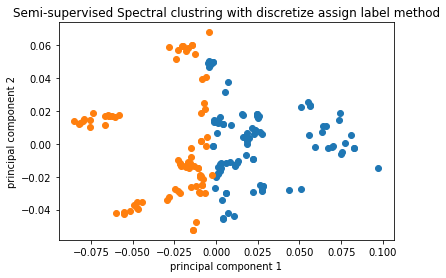

In [158]:
new_paths = ["combined_Bat_Cat_flu.fa"]
k_min = 2
k_max = 6
num_class = 2
kmer_table,output_df = get_kmer_table(new_paths, k_min, k_max)
result,tmp_res = intuitive_semi_supervised(num_class,new_paths,"labels_ten_percent_only0s.csv","discretize",k_min,k_max)
PCA_show_semi_spectural_clustering(num_class,new_paths,"labels_ten_percent_only0s.csv","ten_percent_only0s","discretize",k_min,k_max)

In [159]:
bat_len = len(get_gene_sequences("bat_flu.fa"))

cat_len = len(get_gene_sequences("cat_flu.fa"))

zeros = [0]*bat_len
labels1 = np.append(zeros, [1]*cat_len, axis=None)
temp_accuracy = 1 - sum(abs(labels1 - result))/(bat_len+cat_len)
print("The 10 percent only 0s accuracy based on all true label is: " + str(temp_accuracy) + " for ten percent only 0 labeled dataset.")
allzero = temp_accuracy

df = pd.DataFrame(labels1)
df.to_csv('spectral/labels_PCA.csv')


The 10 percent only 0s accuracy based on all true label is: 0.702247191011236 for ten percent only 0 labeled dataset.


[0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
178
The optimal accuracy based on labeled sequences is: 0.7647058823529411
The optimal k_min is: 3
The optimal k_max is: 3
[0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

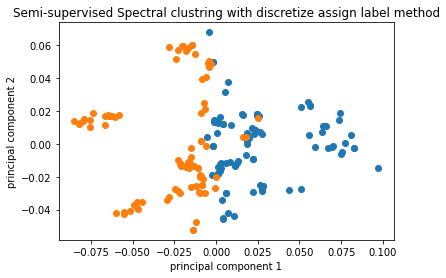

In [160]:
new_paths = ["combined_Bat_Cat_flu.fa"]
k_min = 2
k_max = 6
num_class = 2
kmer_table,output_df = get_kmer_table(new_paths, k_min, k_max)
result, tmp = intuitive_semi_supervised(num_class,new_paths,"labels_ten_percent.csv","discretize",k_min,k_max)
PCA_show_semi_spectural_clustering(num_class,new_paths,"labels_ten_percent.csv","ten_percent","discretize",k_min,k_max)

In [161]:
#pd.set_option("display.max_rows", None, "display.max_columns", None)
#display(pd.DataFrame(list(zip(result,tmp,labels1)),columns=['labels','old','actual']))

In [162]:
bat_len = len(get_gene_sequences("bat_flu.fa"))

cat_len = len(get_gene_sequences("cat_flu.fa"))

zeros = [0]*bat_len
labels1 = np.append(zeros, [1]*cat_len, axis=None)
temp_accuracy = 1 - sum(abs(labels1 - result))/(bat_len+cat_len)
ten = temp_accuracy
print("The 10 percent accuracy based on all true label is: " + str(temp_accuracy) + " for ten percent labeled dataset.")

The 10 percent accuracy based on all true label is: 0.752808988764045 for ten percent labeled dataset.


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
178
The optimal accuracy based on labeled sequences is: 0.7415730337078652
The optimal k_min is: 2
The optimal k_max is: 2
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

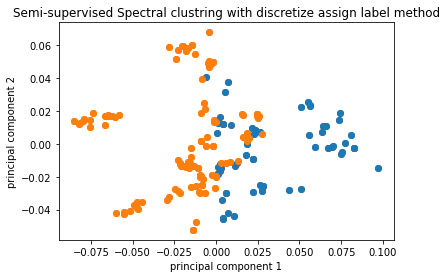

In [163]:
new_paths = ["combined_Bat_Cat_flu.fa"]
k_min = 2
k_max = 6
num_class = 2
kmer_table,output_df = get_kmer_table(new_paths, k_min, k_max)
result, tmp = intuitive_semi_supervised(num_class,new_paths,"labels_fifty_percent.csv","kmeans",k_min,k_max)
PCA_show_semi_spectural_clustering(num_class,new_paths,"labels_fifty_percent.csv","fifty_percent_kmeans","kmeans",k_min,k_max)

result, tmp = intuitive_semi_supervised(num_class,new_paths,"labels_fifty_percent.csv","discretize",k_min,k_max)
PCA_show_semi_spectural_clustering(num_class,new_paths,"labels_fifty_percent.csv","fifty_percent_discretize","discretize",k_min,k_max)

In [164]:
temp_accuracy = 1 - sum(abs(labels1 - result))/(bat_len+cat_len)
fifty = temp_accuracy
print("The 50 percent accuracy based on all true label is: " + str(temp_accuracy) + " for fifty percent labeled dataset.")

The 50 percent accuracy based on all true label is: 0.8707865168539326 for fifty percent labeled dataset.


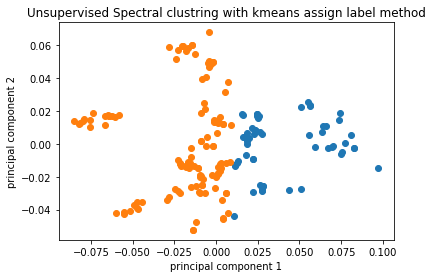

In [165]:
result,output_df = spectral_clustering(2, "kmeans", new_paths, 2, 6)
PCA_show_spectural_clustering(2, "kmeans", new_paths, "unsupervised", 2, 6)

In [166]:
temp_accuracy = 1 - sum(abs(labels1 - result))/(bat_len+cat_len)
unsup = temp_accuracy
print("For unsupervised the accuracy based on all true label is: " + str(temp_accuracy) + " for unlabeled dataset.")

For unsupervised the accuracy based on all true label is: 0.7584269662921348 for unlabeled dataset.


In [167]:
print(unsup)
print(fifty)
print(ten)
print(allzero)

0.7584269662921348
0.8707865168539326
0.752808988764045
0.702247191011236
